# Application sur le FTSE

In [1]:
# Importations de bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg, optimize
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
from sklearn import covariance, cluster
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import yfinance as yf
import statsmodels.api as sm
from statsmodels import regression
import cvxopt as opt
from cvxopt import blas, solvers
from datetime import timedelta


In [2]:
stocks = "FTSE_100"
web = pd.read_html("https://en.wikipedia.org/wiki/{}".format(stocks))[4]

In [3]:
web.head()

,Company,Ticker,FTSE industry classification benchmark sector[25]
0,3i,III,Financial services
1,Admiral Group,ADM,Insurance
2,Airtel Africa,AAF,Telecommunications services
3,Anglo American plc,AAL,Mining
4,Antofagasta plc,ANTO,Mining


In [4]:
tickers = list(web.Ticker)

#Affichage des 5 premiers
tickers[:5]

['III', 'ADM', 'AAF', 'AAL', 'ANTO']

In [5]:
#Définition du début et fin de la collecte de données
start = '2015-01-01'
end = '2016-01-01'

#Collecte
data = yf.download(
    tickers,
    start,
    end
)
data.head()

[****                   9%%                      ]  9 of 100 completed

$STJ: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)
$UU: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)


[********              17%%                      ]  17 of 100 completed

$SMT: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)


[****************      33%%                      ]  33 of 100 completed

$AAF: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)


[**********************69%%*******               ]  69 of 100 completed

$BATS: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)
$AV: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)


[**********************90%%*****************     ]  90 of 100 completed

$SSE: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)


[*********************100%%**********************]  100 of 100 completed

57 Failed downloads:
['STJ', 'UU', 'SMT', 'AAF', 'BATS', 'AV', 'SSE']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2015-01-01 -> 2016-01-01)')
['RR', 'SGE', 'PSH', 'NXT', 'MKS', 'RMV', 'CRDA', 'CTEC', 'WEIR', 'ICG', 'PSN', 'HLN', 'SGRO', 'FRES', 'TW', 'RKT']: YFChartError("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1451624400")
['LGEN', 'HLMA', 'SMDS', 'LLOY', 'CCH', 'FCIT', 'LSEG', 'HWDN', 'INF', 'FRAS', 'GLEN', 'EXPN', 'BARC', 'NG.', 'IMI', 'HSBA', 'BRBY', 'PHNX', 'MNDI', 'SDR', 'SN.', 'SBRY', 'BT-A', 'OCDO', 'BNZL', 'ITRK', 'RS1', 'AUTO', 'PSON', 'BDEV', 'DPLM', 'ENT', 'ULVR', 'ANTO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Price      Adj Close                                                         \
Ticker           AAF        AAL    ABF        ADM         AHT ANTO AUTO  AV   
Date                                                                          
2015-01-02       NaN  51.079906  0.044  39.839653  703.254150  NaN  NaN NaN   
2015-01-05       NaN  51.051483  0.044  38.461128  701.917175  NaN  NaN NaN   
2015-01-06       NaN  50.255585  0.044  37.702927  692.558228  NaN  NaN NaN   
2015-01-07       NaN  50.227150  0.044  38.269653  697.906311  NaN  NaN NaN   
2015-01-08       NaN  50.843044  0.044  37.710583  705.928162  NaN  NaN NaN   

Price                              ... Volume                                \
Ticker            AZN          BA  ...    SVT     TSCO  TW ULVR     UTG  UU   
Date                               ...                                        
2015-01-02  25.526251  113.657211  ...      0   557100 NaN  NaN   75600 NaN   
2015-01-05  25.330452  112.870079  ...   1000   998000 NaN  NaN  165200 NaN   
2015-01-06  24.714052  111.540611  ...      0  1347500 NaN  NaN   73700 NaN   
2015-01-07  24.688665  113.272377  ...      0  1431900 NaN  NaN   56400 NaN   
2015-01-08  25.044006  115.275269  ...      0  1942600 NaN  NaN  107100 NaN   

Price                                 
Ticker          VOD WEIR    WPP  WTB  
Date                                  
2015-01-02  2555900  NaN  41900  0.0  
2015-01-05  5437600  NaN  56900  0.0  
2015-01-06  4899800  NaN  73100  0.0  
2015-01-07  4918800  NaN  67700  0.0  
2015-01-08  4965300  NaN  55300  0.0  

[5 rows x 600 columns]

In [6]:
failed_tickers = data.columns.get_level_values(1)[data.isnull().any() | (data == 0).any()].unique().tolist()
tickers = [ticker for ticker in tickers if ticker not in failed_tickers]

In [7]:
data.drop(columns=failed_tickers, level=1, inplace=True)
data.head()

Price       Adj Close                                                \
Ticker            AAL        ADM         AHT        AZN          BA   
Date                                                                  
2015-01-02  51.079906  39.839653  703.254150  25.526251  113.657211   
2015-01-05  51.051483  38.461128  701.917175  25.330452  112.870079   
2015-01-06  50.255585  37.702927  692.558228  24.714052  111.540611   
2015-01-07  50.227150  38.269653  697.906311  24.688665  113.272377   
2015-01-08  50.843044  37.710583  705.928162  25.044006  115.275269   

Price                                                             ...  \
Ticker            BME         BP        CNA        GSK        HL  ...   
Date                                                              ...   
2015-01-02  20.921051  21.803951  18.620770  26.075600  2.719583  ...   
2015-01-05  20.247297  20.648542  18.073811  25.792513  2.805766  ...   
2015-01-06  20.207670  20.494108  17.720470  25.650970  2.968559  ...   
2015-01-07  20.534641  20.545584  17.826952  25.915598  2.901528  ...   
2015-01-08  20.712992  21.008892  18.267429  26.580254  2.805766  ...   

Price         Volume                                                     \
Ticker           MRO     NWG      PRU      RIO     SHEL   SMIN     TSCO   
Date                                                                      
2015-01-02   5279400  350506  1696100  1573200  4496666  41200   557100   
2015-01-05   7905100  413981  2665400  3017700  7235318  23000   998000   
2015-01-06  11316400  695258  3957500  4357200  7664435  17800  1347500   
2015-01-07   7213700  380666  2585600  2919200  4969365  19200  1431900   
2015-01-08  11658200  232742  2172500  2797100  4673947  38700  1942600   

Price                               
Ticker         UTG      VOD    WPP  
Date                                
2015-01-02   75600  2555900  41900  
2015-01-05  165200  5437600  56900  
2015-01-06   73700  4899800  73100  
2015-01-07   56400  4918800  67700  
2015-01-08  107100  4965300  55300  

[5 rows x 150 columns]

In [8]:
data.columns

MultiIndex([('Adj Close',  'AAL'),
            ('Adj Close',  'ADM'),
            ('Adj Close',  'AHT'),
            ('Adj Close',  'AZN'),
            ('Adj Close',   'BA'),
            ('Adj Close',  'BME'),
            ('Adj Close',   'BP'),
            ('Adj Close',  'CNA'),
            ('Adj Close',  'GSK'),
            ('Adj Close',   'HL'),
            ...
            (   'Volume',  'MRO'),
            (   'Volume',  'NWG'),
            (   'Volume',  'PRU'),
            (   'Volume',  'RIO'),
            (   'Volume', 'SHEL'),
            (   'Volume', 'SMIN'),
            (   'Volume', 'TSCO'),
            (   'Volume',  'UTG'),
            (   'Volume',  'VOD'),
            (   'Volume',  'WPP')],
           names=['Price', 'Ticker'], length=150)

In [9]:
s= set()
for column,_ in list(data.columns):
    s.add(column)
s

{'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'}

In [10]:
closing_prices = data["Close"]
opening_prices = data["Open"]

variation = closing_prices-opening_prices
variation.head()

Ticker,AAL,ADM,AHT,AZN,BA,BME,BP,CNA,GSK,HL,...,MRO,NWG,PRU,RIO,SHEL,SMIN,TSCO,UTG,VOD,WPP
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.369999,-0.180000,-0.988159,-0.334999,-1.120010,-0.990002,-0.090000,-0.279999,-0.330002,0.09,...,0.540001,-0.107759,-0.900002,-0.009998,-0.039993,-0.400002,-0.730003,0.020000,-0.050003,-0.810005
2015-01-05,-0.489998,-1.230000,2.964478,-0.224998,-0.610001,-1.230000,-0.490002,-0.750000,0.290001,0.08,...,-0.770000,-0.043104,-2.449997,0.170002,-1.090000,0.090000,-1.470001,-1.320002,-0.339996,-1.430000
2015-01-06,-1.230000,-1.230000,-15.810242,-0.514999,-1.520004,-0.129997,-0.179996,-0.770000,-0.049999,0.17,...,-0.269999,-0.237069,-1.570000,0.349998,-0.579998,-0.620003,-0.989998,0.030001,-0.310001,-1.110001
2015-01-07,-0.370003,0.270000,-0.988037,0.094997,0.769989,0.420002,-0.080002,-0.160000,0.350002,-0.03,...,-0.119999,-0.010777,-0.810005,0.610001,0.279999,0.730000,2.239998,0.420000,-0.009998,0.349998
2015-01-08,0.180000,-0.049999,10.869629,0.264999,1.199997,-0.189999,0.299999,0.530003,0.309998,-0.10,...,0.110001,0.140086,0.470001,0.189999,0.770004,0.520000,1.500000,-0.030003,0.270000,1.240005


In [11]:
alphas = np.logspace(-1.5, 1, num=10)
model = covariance.GraphicalLassoCV(alphas=alphas)

X = variation.copy()
X /= X.std(axis=0)
model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

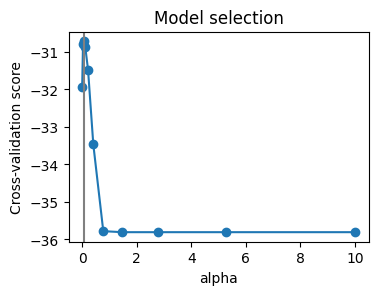

In [12]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()

In [13]:
model.alpha_

0.05994842503189409

In [14]:
_, labels = cluster.affinity_propagation(model.covariance_, random_state=0)
n_labels = labels.max()
n_labels

6

In [15]:
labels

array([6, 6, 6, 6, 6, 0, 5, 6, 6, 1, 1, 6, 2, 3, 4, 5, 6, 6, 5, 5, 6, 6,
       6, 6, 6], dtype=int64)

In [16]:
clusters = {}

for i in range(len(labels)):
    cluster = labels[i]+1
    if cluster not in clusters:
        clusters[cluster]=[]
    clusters[cluster].append(tickers[i])

for cluster in clusters:
    print("Cluster "+str(cluster)+" : "+",".join(clusters[cluster]))

Cluster 7 : III,ADM,AAL,AHT,AZN,BP,CNA,IHG,NWG,PRU,SMIN,TSCO,UTG,VOD,WPP
Cluster 1 : BME
Cluster 6 : BA,MRO,RIO,SHEL
Cluster 2 : GSK,HL
Cluster 3 : IAG
Cluster 4 : JD
Cluster 5 : LAND


In [17]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

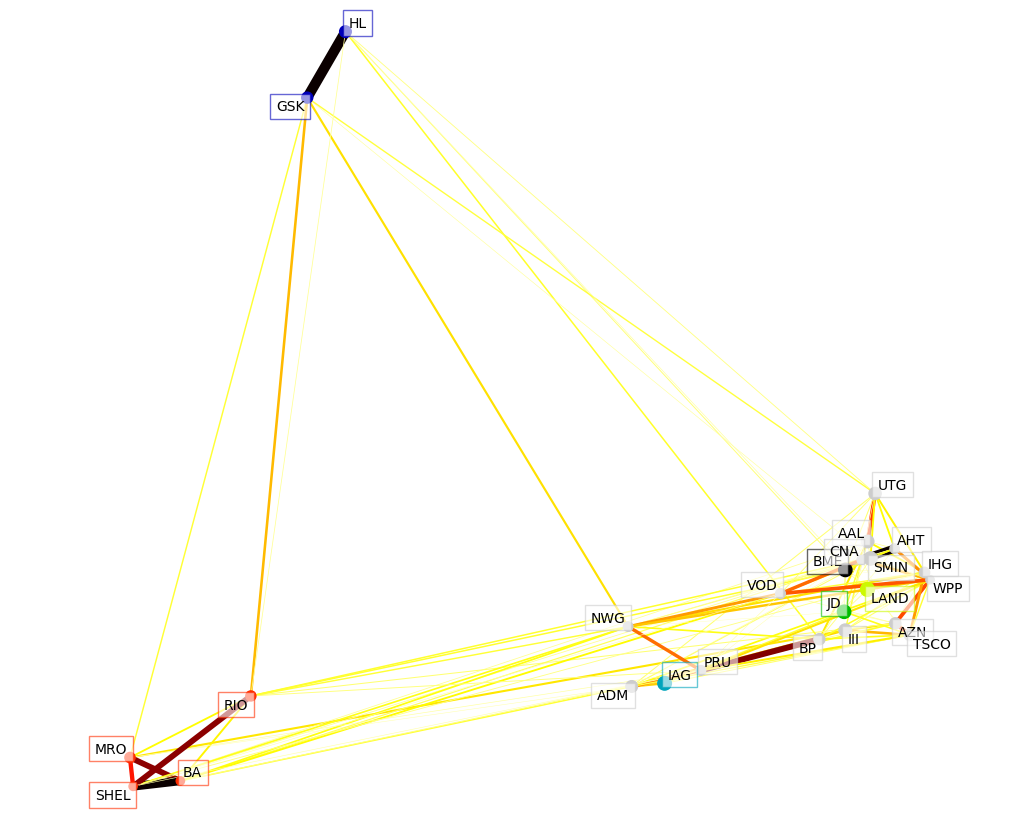

In [18]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")


partial_correlations = model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02


plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

start_idx, end_idx = np.where(non_zero)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(zip(tickers, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()